In [45]:
%load_ext autoreload

%autoreload 2
from utils import parse_table, read_csv
import pandas as pd
import numpy as np

from pretty import plot_kde, ColorTheme

std_in_df = read_csv('likelihood/std_in.csv')
std_out_df = read_csv('likelihood/std_out.csv')
mean_in_df = read_csv('likelihood/mean_in.csv')
mean_out_df = read_csv('likelihood/mean_out.csv')
auc_all_df = read_csv('likelihood/auc_all.csv')

plotting_map = {
    'fashion-mnist': 'FMNIST',
    'mnist': 'MNIST',
    'emnist': 'EMNIST',
    'omniglot': 'Omniglot',
    'celeba-small': 'CelebA',
    'svhn': 'SVHN',
    'cifar10': 'CIFAR10',
    'cifar100': 'CIFAR100',
    'tiny-imagenet': 'Tiny',
}

def parse_name(name):
    in_distr, _, ood, _, _, _, num_samples, _, _, num_steps, _ = name.split('_')
    num_samples = int(num_samples)
    num_steps = int(num_steps)
    return in_distr, ood, num_samples, num_steps


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
auc_all_df


,_defaultColorIndex,auc,id,name,num_samples
0,7,1.000000,i299cbfy,mnist_vs_fashion-mnist_test_num_samples_500_nu...,500
1,6,1.000000,1t678taz,svhn_vs_cifar10_test_num_samples_500_num_steps...,500
2,5,0.000000,pyhsrmsa,cifar10_vs_svhn_test_num_samples_500_num_steps...,500
3,4,0.015625,3e59tgq9,fashion-mnist_vs_mnist_test_num_samples_500_nu...,500
4,3,1.000000,pe3klinb,mnist_vs_fashion-mnist_test_num_samples_100_nu...,100
...,...,...,...,...,...
275,4,0.046875,dhs0ngd2,fashion-mnist_vs_mnist_test_num_samples_5_num_...,5
276,3,1.000000,282o3j59,mnist_vs_fashion-mnist_test_num_samples_1_num_...,1
277,2,1.000000,00s6va7q,svhn_vs_cifar10_test_num_samples_1_num_steps_2...,1
278,1,0.000000,95u7cool,cifar10_vs_svhn_test_num_samples_1_num_steps_2...,1


In [82]:
from typing import Literal
from pretty import plot_trends
from pretty import ColorTheme


def get_likelihood_plot_for_task(in_distr, ood, sweep_type: Literal['num_steps', 'num_samples'], fixed_sweep: int):
    map_x_to_std_in = {}
    for idx, row in std_in_df.iterrows():
        in_distr_, ood_, num_samples, num_steps = parse_name(row['name'])
        if in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_samples' and num_steps == fixed_sweep:
            map_x_to_std_in[num_samples] = row['std_in_log_probs']
        elif in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_steps' and num_samples == fixed_sweep:
            map_x_to_std_in[num_steps] = row['std_in_log_probs']
    map_x_to_std_out = {}
    for idx, row in std_out_df.iterrows():
        in_distr_, ood_, num_samples, num_steps = parse_name(row['name'])
        if in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_samples' and num_steps == fixed_sweep:
            map_x_to_std_out[num_samples] = row['std_out_log_probs']
        elif in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_steps' and num_samples == fixed_sweep:
            map_x_to_std_out[num_steps] = row['std_out_log_probs']
    map_x_to_mean_in = {}
    for idx, row in mean_in_df.iterrows():
        in_distr_, ood_, num_samples, num_steps = parse_name(row['name'])
        if in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_samples' and num_steps == fixed_sweep:
            map_x_to_mean_in[num_samples] = row['mean_in_log_prob']
        elif in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_steps' and num_samples == fixed_sweep:
            map_x_to_mean_in[num_steps] = row['mean_in_log_prob']
    map_x_to_mean_out = {}
    for idx, row in mean_out_df.iterrows():
        in_distr_, ood_, num_samples, num_steps = parse_name(row['name'])
        if in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_samples' and num_steps == fixed_sweep:
            map_x_to_mean_out[num_samples] = row['mean_out_log_prob']
        elif in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_steps' and num_samples == fixed_sweep:
            map_x_to_mean_out[num_steps] = row['mean_out_log_prob']
    x_axis = sorted(list(map_x_to_std_in.keys()))
    mean_in = [map_x_to_mean_in[x] for x in x_axis]
    std_in = [map_x_to_std_in[x] for x in x_axis]
    mean_out = [map_x_to_mean_out[x] for x in x_axis]
    std_out = [map_x_to_std_out[x] for x in x_axis]
    return np.array(x_axis), np.array(mean_in), np.array(std_in), np.array(mean_out), np.array(std_out)


def get_auc_plot_for_task(in_distr, ood, sweep_type: Literal['num_steps', 'num_samples'], fixed_sweep: int):
    map_x_to_auc = {}
    for idx, row in auc_all_df.iterrows():
        in_distr_, ood_, num_samples, num_steps = parse_name(row['name'])
        if in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_samples' and num_steps == fixed_sweep:
            map_x_to_auc[num_samples] = row['auc']
        elif in_distr == in_distr_ and ood_ == ood and sweep_type == 'num_steps' and num_samples == fixed_sweep:
            map_x_to_auc[num_steps] = row['auc']
    x_axis = sorted(list(map_x_to_auc.keys()))
    aucs = [map_x_to_auc[x] for x in x_axis]
    return np.array(x_axis), np.array(aucs)



Calculating for fashion-mnist mnist num_steps 500
Calculating for fashion-mnist mnist num_samples 2
Calculating for mnist fashion-mnist num_steps 500
Calculating for mnist fashion-mnist num_samples 2
Calculating for cifar10 svhn num_steps 500
Calculating for cifar10 svhn num_samples 2
Calculating for svhn cifar10 num_steps 500
Calculating for svhn cifar10 num_samples 2


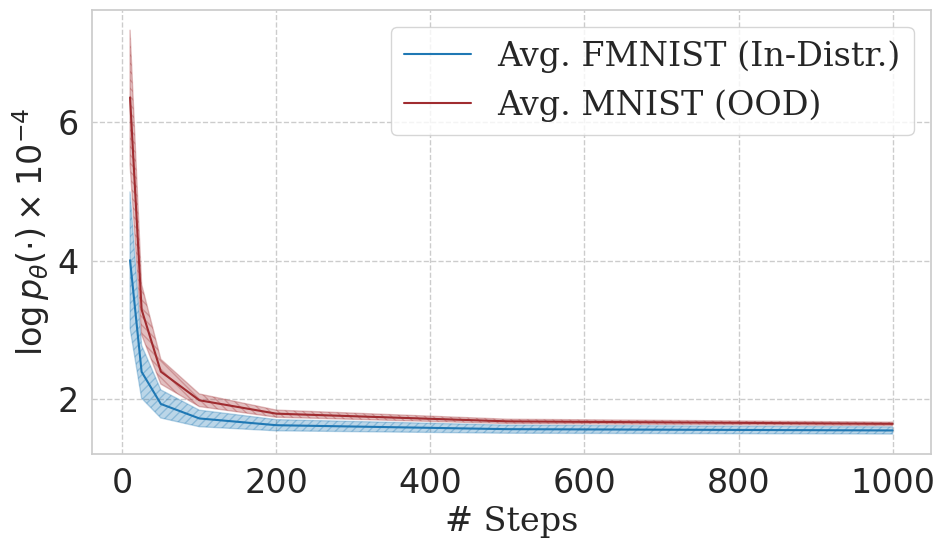

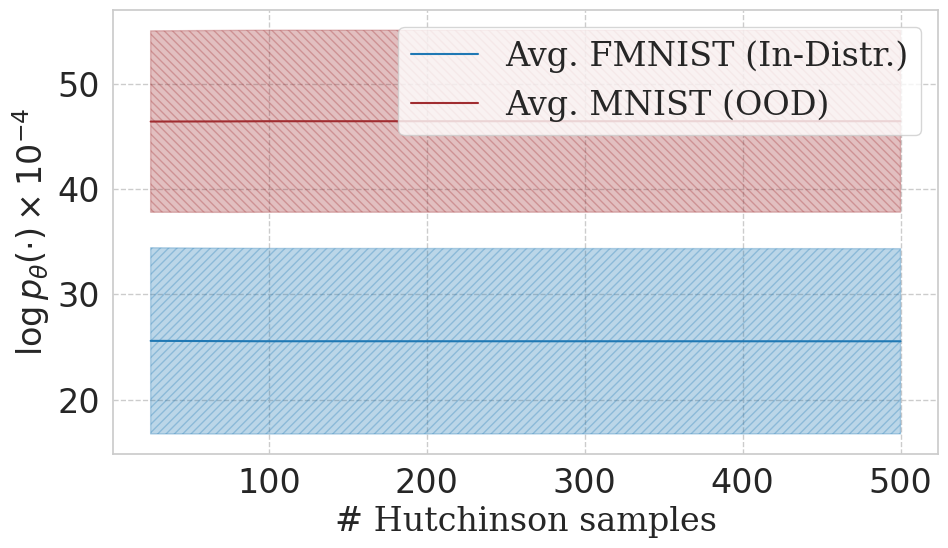

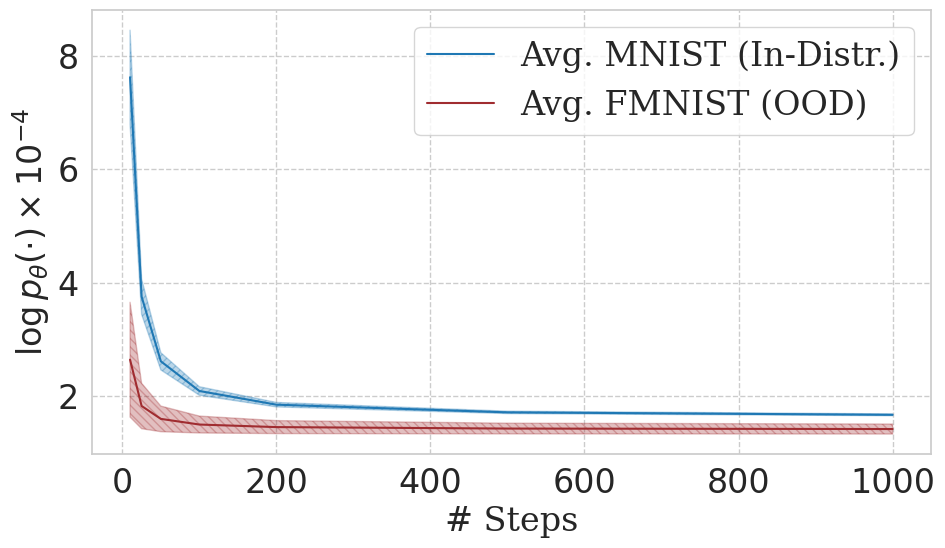

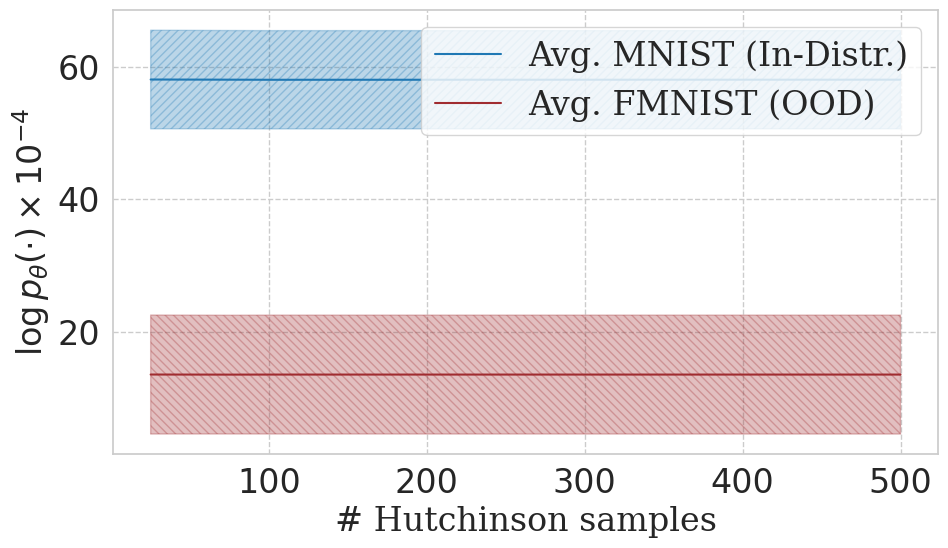

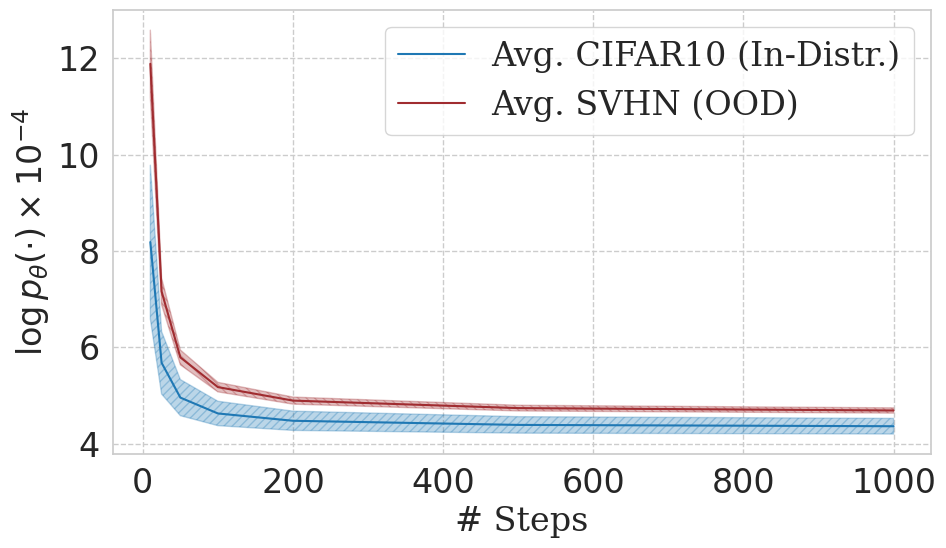

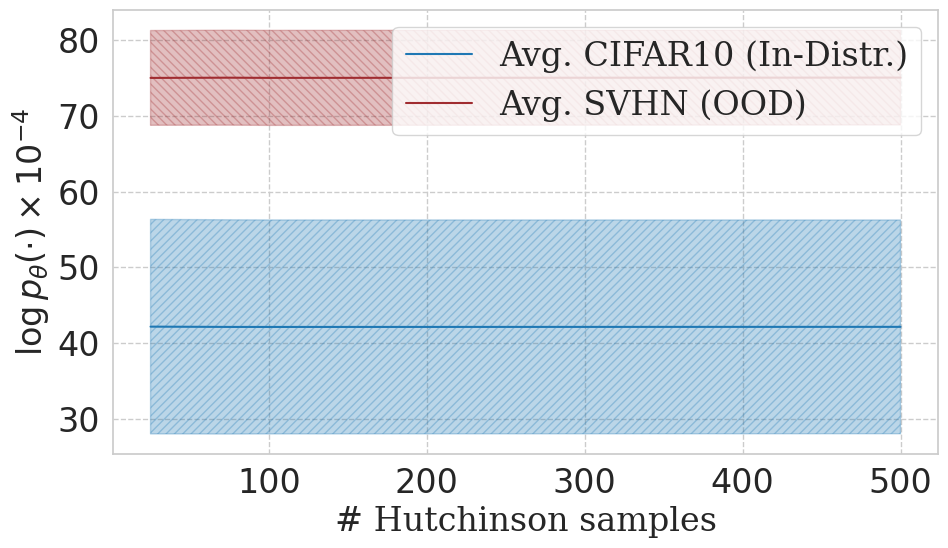

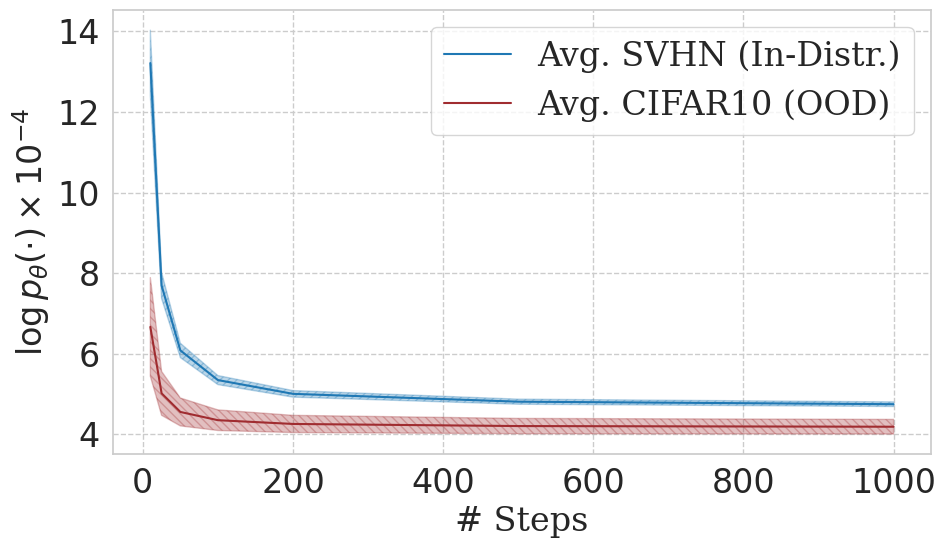

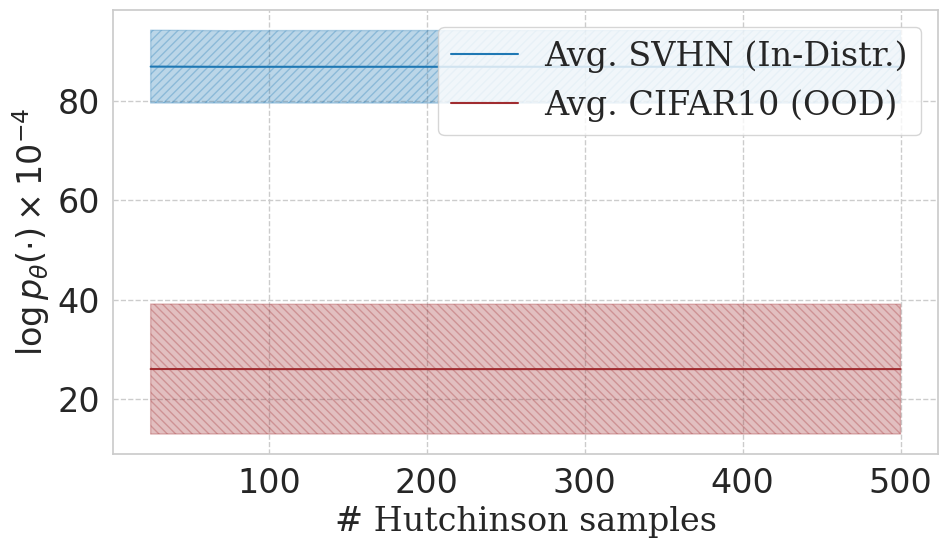

In [103]:
task_list = [
    ('fashion-mnist', 'mnist', 'num_steps', 500, 3),
    ('fashion-mnist', 'mnist', 'num_samples', 2, 3),
    ('mnist', 'fashion-mnist', 'num_steps', 500, 3),
    ('mnist', 'fashion-mnist', 'num_samples', 2, 3),
    ('cifar10', 'svhn', 'num_steps', 500, 3),
    ('cifar10', 'svhn', 'num_samples', 2, 3),
    ('svhn', 'cifar10', 'num_steps', 500, 3),
    ('svhn', 'cifar10', 'num_samples', 2, 3),
]

for in_distr, ood, sweep_type, fixed_sweep, start_idx in task_list:

    print("Calculating for", in_distr, ood, sweep_type, fixed_sweep)
    x_axis, mean_in, std_in, mean_out, std_out = get_likelihood_plot_for_task(in_distr, ood, sweep_type, fixed_sweep)
    x_axis = x_axis[start_idx:]
    mean_in = mean_in[start_idx:]
    std_in = std_in[start_idx:]
    mean_out = mean_out[start_idx:]
    std_out = std_out[start_idx:]

    plot_trends(
        t_values=x_axis,
        mean_values=[mean_in / 10000, mean_out/ 10000],
        std_values=[std_in / 10000, std_out / 10000],
        colors=[ColorTheme.IN_DISTR.value, ColorTheme.OOD.value],
        labels= [f'{plotting_map[in_distr]} (In-Distr.)', f'{plotting_map[ood]} (OOD)'],
        # horizontal_lines_color=[ColorTheme.DARK_DENSITY.value for _ in range(5)],
        # horizontal_lines_thickness=2,
        # horizontal_lines=[lpca_estimates[i] for i in range(5)],
        x_label=f'# Hutchinson samples' if sweep_type == 'num_samples' else f'# Steps',
        y_label='$\\log p_\\theta(\\cdot) \\times 10^{-4}$',
        figsize = (10, 6),
        file_name=f'{in_distr}_vs_{ood}_sweep_on_{sweep_type}_fixed_{fixed_sweep}',
        # custom_xticks=x_axis.tolist(),
        # legend_fontsize=18,
        legend_loc='upper right',
    )

Calculating for fashion-mnist mnist num_steps 25
Calculating for fashion-mnist mnist num_samples 25
Calculating for mnist fashion-mnist num_steps 25
Calculating for mnist fashion-mnist num_samples 25
Calculating for cifar10 svhn num_steps 25
Calculating for cifar10 svhn num_samples 25
Calculating for svhn cifar10 num_steps 25
Calculating for svhn cifar10 num_samples 25


<Axes: xlabel='# Hutchinson samples', ylabel='AUC-ROC'>

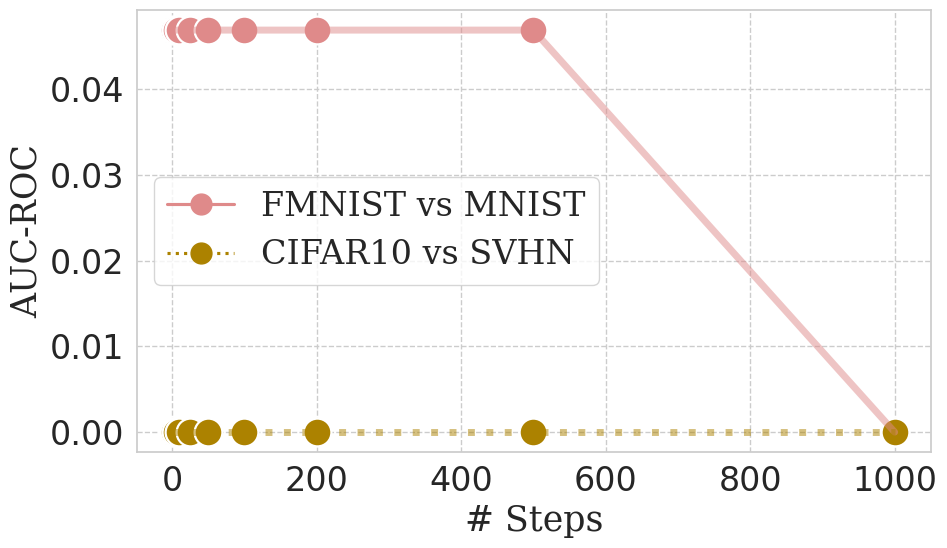

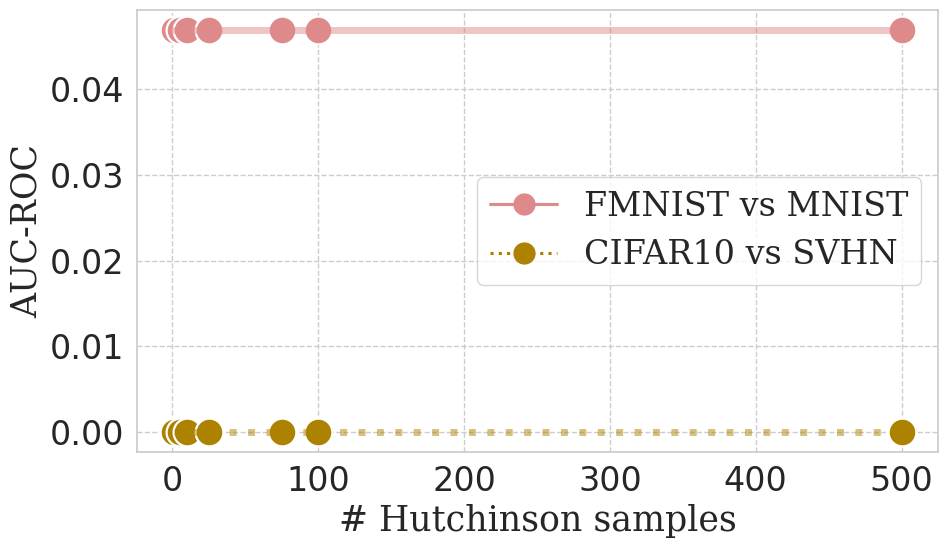

In [111]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pretty import ColorTheme, plot_linechart

task_list = [
    ('fashion-mnist', 'mnist', 'num_steps', 25),
    ('fashion-mnist', 'mnist', 'num_samples', 25),
    ('mnist', 'fashion-mnist', 'num_steps', 25),
    ('mnist', 'fashion-mnist', 'num_samples', 25),
    ('cifar10', 'svhn', 'num_steps', 25),
    ('cifar10', 'svhn', 'num_samples', 25),
    ('svhn', 'cifar10', 'num_steps', 25),
    ('svhn', 'cifar10', 'num_samples', 25),
]

labels = []
num_samples_x_axis = []
num_samples_auc = []
num_steps_x_axis = []
num_steps_auc = []
for in_distr, ood, sweep_type, fixed_sweep in task_list:

    print("Calculating for", in_distr, ood, sweep_type, fixed_sweep)
    x_axis, aucs = get_auc_plot_for_task(in_distr, ood, sweep_type, fixed_sweep)
    if sweep_type == 'num_samples':
        labels.append(f'{plotting_map[in_distr]} vs {plotting_map[ood]}')
        num_samples_x_axis.append(x_axis)
        num_samples_auc.append(aucs)
    elif sweep_type == 'num_steps':
        num_steps_x_axis.append(x_axis)
        num_steps_auc.append(aucs)


plot_linechart(
    x_values = num_steps_x_axis[0],
    y_values = [num_steps_auc[0], num_steps_auc[2]],
    labels = [labels[0], labels[2]],
    markers = [
        # 's',
        'o',
        'o',
        # '+',
    ],
    trend_markers = [
        '-',
        ':',
        # '-',
        # ':',
    ],
    alpha=0.5,
    
    colors = [
        # ColorTheme.IN_DISTR.value,
        # ColorTheme.OOD.value,
        # ColorTheme.IN_DISTR_SECONDARY.value,
        ColorTheme.OOD_SECONDARY.value,
        # ColorTheme.DENSITY.value,
        ColorTheme.DARK_DENSITY.value,
    ],
    figsize=(10, 6),
    fontsize=25,
    thickness_coeff= 4.0,
    relative_thickness=0.5,
    
    x_label='# Steps',
    y_label='AUC-ROC',
    
    # custom_xticks: th.Optional[th.List] = None,
    # tick_fontsize: th.Optiobal[int] = None,
    
    # legend_fontsize = 16,
    # legend_loc='lower left',
    legend_marker_size=15,
    
    file_name='num_steps_vs_auc_across_tasks',
)

plot_linechart(
    x_values = num_samples_x_axis[0],
    y_values = [num_samples_auc[0], num_samples_auc[2]],
    labels = [labels[0], labels[2]],
    markers = [
        # 's',
        'o',
        'o',
        # '+',
    ],
    trend_markers = [
        '-',
        ':',
        # '-',
        # ':',
    ],
    alpha=0.5,
    
    colors = [
        # # ColorTheme.IN_DISTR.value,
        # # ColorTheme.OOD.value,
        # ColorTheme.IN_DISTR_SECONDARY.value,
        ColorTheme.OOD_SECONDARY.value,
        # ColorTheme.DENSITY.value,
        ColorTheme.DARK_DENSITY.value,
    ],
    figsize=(10, 6),
    fontsize=25,
    thickness_coeff= 4.0,
    relative_thickness=0.5,
    
    x_label='# Hutchinson samples',
    y_label='AUC-ROC',
    
    # custom_xticks: th.Optional[th.List] = None,
    # tick_fontsize: th.Optiobal[int] = None,
    
    # legend_fontsize = 16,
    # legend_loc='lower left',
    legend_marker_size=15,
    
    file_name='num_samples_vs_auc_across_tasks',
)

